In [ ]:
#Loading libraries:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda
import matplotlib.pyplot as plt

In [ ]:
#Loading data:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

batch_size = 64
train_loader = DataLoader(dataset=training_data, batch_size=batch_size)
test_loader = DataLoader(dataset=test_data, batch_size=batch_size)

for X, y in train_loader:
  print(f"Shape of X [N, C, H, W]: {X.shape}")
  print(f"Shape of y: {y.shape} {y.dtype}")
  break

100%|██████████| 26.4M/26.4M [00:03<00:00, 7.91MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 137kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 2.55MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 12.0MB/s]

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


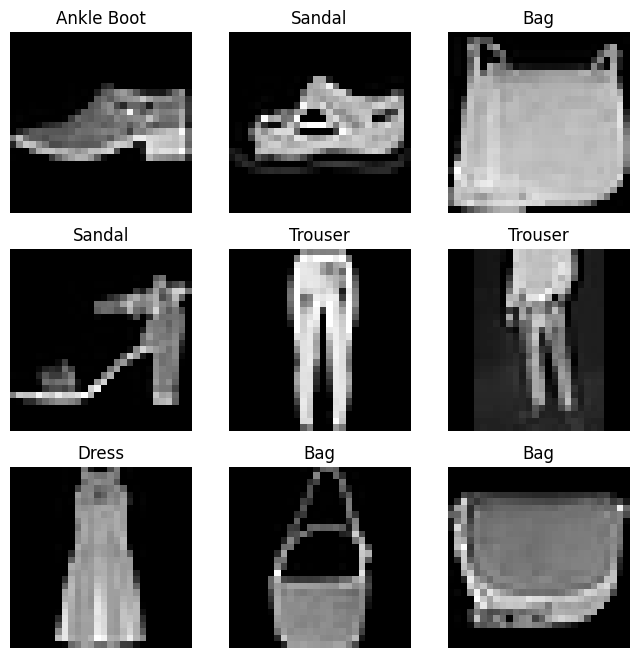

In [ ]:
#show a samle of the FashionMNIST data:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols*rows+1):
  sample_idx = torch.randint(len(training_data), size=(1,)).item()
  img, label = training_data[sample_idx]
  figure.add_subplot(rows, cols, i)
  plt.title(labels_map[label])
  plt.axis("off")
  plt.imshow(img.squeeze(), cmap="gray")
plt.show()

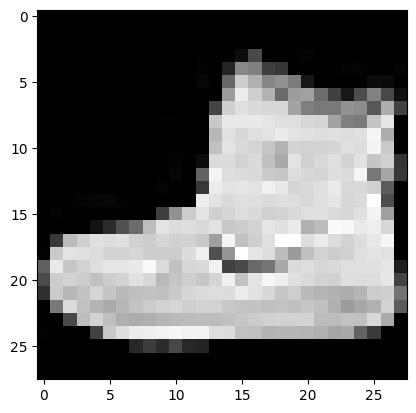

In [ ]:
train_features, train_labels = next(iter(train_loader))
img = train_features[0].squeeze()
plt.imshow(img, cmap="gray")

In [ ]:
#data transforms:
ds = datasets.FashionMNIST

In [ ]:
#Creating models:
#use accelerator
device = torch.accelerator.current_accelerator().type() if torch.accelerator.is_available() else "cpu"
print(f"UsNeuralNetworking {device} device")

#define model
class NeuralNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.flatten = nn.Flatten()
    self.linear_relu_stack = nn.Sequential(
        nn.Linear(28*28, 512),
        nn.ReLU(),
        nn.Linear(512, 512),
        nn.ReLU(),
        nn.Linear(512, 10)
    )

  def forward(self, x):
    x = self.flatten(x)
    logits = self.linear_relu_stack(x)
    return logits

model = NeuralNetwork().to(device)
print(model)

UsNeuralNetworking cpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [ ]:
#Optimizing the model parameters:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

def train(dataloader, model, loss_fn, optimizer):
  size = len(dataloader.dataset)
  model.train()
  for batch_id, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)

    pred = model(X)
    loss = loss_fn(pred, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if batch_id % 100 == 0:
      loss, current = loss.item(), (batch_id+1)*len(X)
      print(f"loss: {loss:>7f} [{current:>5d}/{size:>5d}]")


def test(dataloader, model, loss_fn):
  size = len(dataloader.dataset)
  num_batches = len(dataloader)
  model.eval()
  test_loss, correct = 0, 0
  with torch.no_grad():
    for X, y in dataloader:
      X, y = X.to(device), y.to(device)

      pred = model(X)
      test_loss += loss_fn(pred, y).item()
      correct += (pred.argmax(1) == y).type(torch.float).sum().item()
  test_loss /= num_batches
  correct /= size
  print(f"Total test Error: \n Accuracy: {(correct*100):>0.1f}%, Avg loss: {test_loss:>8f} \n")


epochs = 5
for t in range(epochs):
  print(f"Epoch {t+1}\n-----------------------------")
  train(train_loader, model, loss_fn, optimizer)
  test(test_loader, model, loss_fn)
print("Done!")

Epoch 1
-----------------------------
loss: 2.291494 [   64/60000]
loss: 2.283642 [ 6464/60000]
loss: 2.268486 [12864/60000]
loss: 2.269045 [19264/60000]
loss: 2.260948 [25664/60000]
loss: 2.210658 [32064/60000]
loss: 2.227767 [38464/60000]
loss: 2.178774 [44864/60000]
loss: 2.170534 [51264/60000]
loss: 2.165347 [57664/60000]
Total test Error: 
 Accuracy: 38.5%, Avg loss: 2.148441 

Epoch 2
-----------------------------
loss: 2.145420 [   64/60000]
loss: 2.145526 [ 6464/60000]
loss: 2.084543 [12864/60000]
loss: 2.108992 [19264/60000]
loss: 2.070633 [25664/60000]
loss: 1.985970 [32064/60000]
loss: 2.025679 [38464/60000]
loss: 1.928022 [44864/60000]
loss: 1.927305 [51264/60000]
loss: 1.887730 [57664/60000]
Total test Error: 
 Accuracy: 58.7%, Avg loss: 1.872350 

Epoch 3
-----------------------------
loss: 1.890742 [   64/60000]
loss: 1.877687 [ 6464/60000]
loss: 1.751498 [12864/60000]
loss: 1.804489 [19264/60000]
loss: 1.715795 [25664/60000]
loss: 1.638191 [32064/60000]
loss: 1.677296 [

In [ ]:
#saving model:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch model state to model.pth")

Saved PyTorch model state to model.pth


In [ ]:
#loading the model:
model.NeuralNetwork().to(device)
model.load_state_dict(torch.load("model.pth", weights_only=True))

In [ ]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    x = x.to(device)
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle boot", Actual: "Ankle boot"
